In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from scipy.stats import norm
import scipy.stats as sps
import cv2
from scipy.ndimage import convolve
import skimage
from scipy import ndimage
from scipy.spatial.distance import cdist
from nibabel.testing import data_path
import nibabel as nib
from sklearn.mixture import GaussianMixture
import pandas as pd
import skimage.measure
import seaborn as sns
import scipy as sp
import gudhi as gd
import random
from function_geometry import * 
from codegeometry import * 
from PIL import Image
from gtda.diagrams import HeatKernel, Scaler
from gtda.images import Binarizer, RadialFiltration
from gtda.homology import CubicalPersistence
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import similaritymeasures 


# Importing TDA modules
from gtda.plotting import plot_point_cloud
import matplotlib.pyplot as plt
from gtda.diagrams import PersistenceLandscape, Silhouette, PersistenceEntropy, NumberOfPoints, Amplitude
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline, make_union
from gtda.images import HeightFiltration
from gtda.images import RadialFiltration

# Importing Geo modules

from feature_utils import *

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2023-06-07 10:13:01.083294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


modules loaded


In [2]:
path_train_b = "./data/train/benign/"
path_train_m = "./data/train/malignant/"
path_test_b = "./data/test/benign/"
path_test_m = "./data/test/malignant/"

In [469]:
from sklearn.utils import shuffle

m_train = 2000
m_test = 1000

U_train_b_rgb = preprocessing_data_rgb(path_train_b, m_train)
U_train_m_rgb = preprocessing_data_rgb(path_train_m, m_train)
U_test_b_rgb = preprocessing_data_rgb(path_test_b, m_test)
U_test_m_rgb = preprocessing_data_rgb(path_test_m, m_test)


U_train_b = preprocessing_data(path_train_b, m_train)
U_train_m = preprocessing_data(path_train_m, m_train)
U_test_b = preprocessing_data(path_test_b, m_test)
U_test_m = preprocessing_data(path_test_m, m_test)


U_train_rgb = np.asarray(U_train_b_rgb + U_train_m_rgb)
y_train = [0]*len(U_train_b) + [1]*len(U_train_m)

U_test_rgb = np.asarray(U_test_b_rgb + U_test_m_rgb)
y_test = [0]*len(U_test_b) + [1]*len(U_test_m)

U_train = np.asarray(U_train_b + U_train_m)
U_test = np.asarray(U_test_b + U_test_m)

In [470]:
len(U_train), len(U_test), len(y_train)

(2637, 660, 2637)

In [6]:
# Concatenate elementwise
combined_list = list(zip(U_train, y_train))

# Fix the seed for reproducibility
random.seed(42)

# Shuffle the combined list
random.shuffle(combined_list)

# Separate the shuffled elements
shuffled_list1, shuffled_list2 = zip(*combined_list)


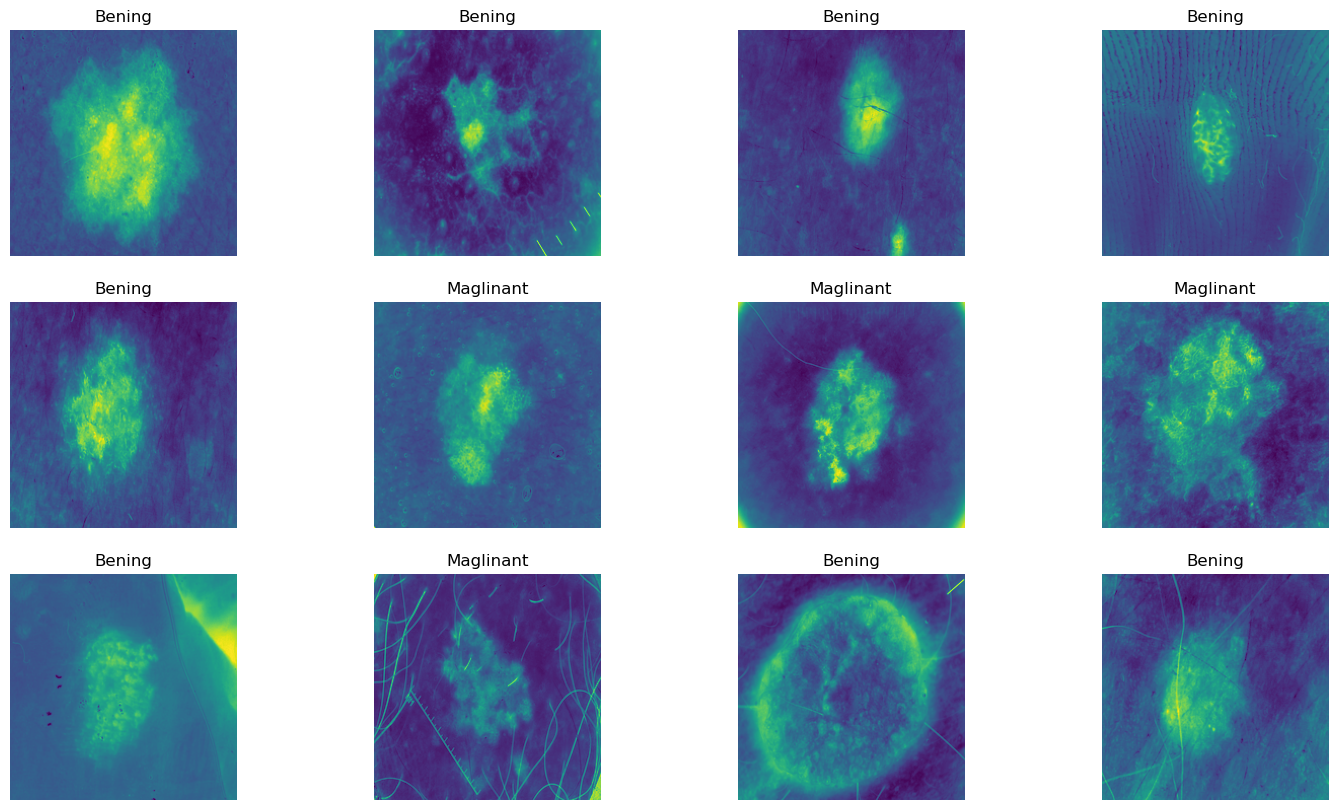

In [7]:
import matplotlib.pyplot as plt

class_names = ['Bening', 'Maglinant']
    
plt.figure(figsize=(18, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(shuffled_list1[i].astype("uint32"))
    plt.title(class_names[shuffled_list2[i]])
    plt.axis("off")
plt.show()



In [8]:
# Concatenate elementwise
combined_list_rgb = list(zip(U_train_rgb, y_train))

# Fix the seed for reproducibility
random.seed(42)

# Shuffle the combined list
random.shuffle(combined_list_rgb)

# Separate the shuffled elements
shuffled_list1_rgb, shuffled_list2_rgb = zip(*combined_list_rgb)

# Visualise image augmentation

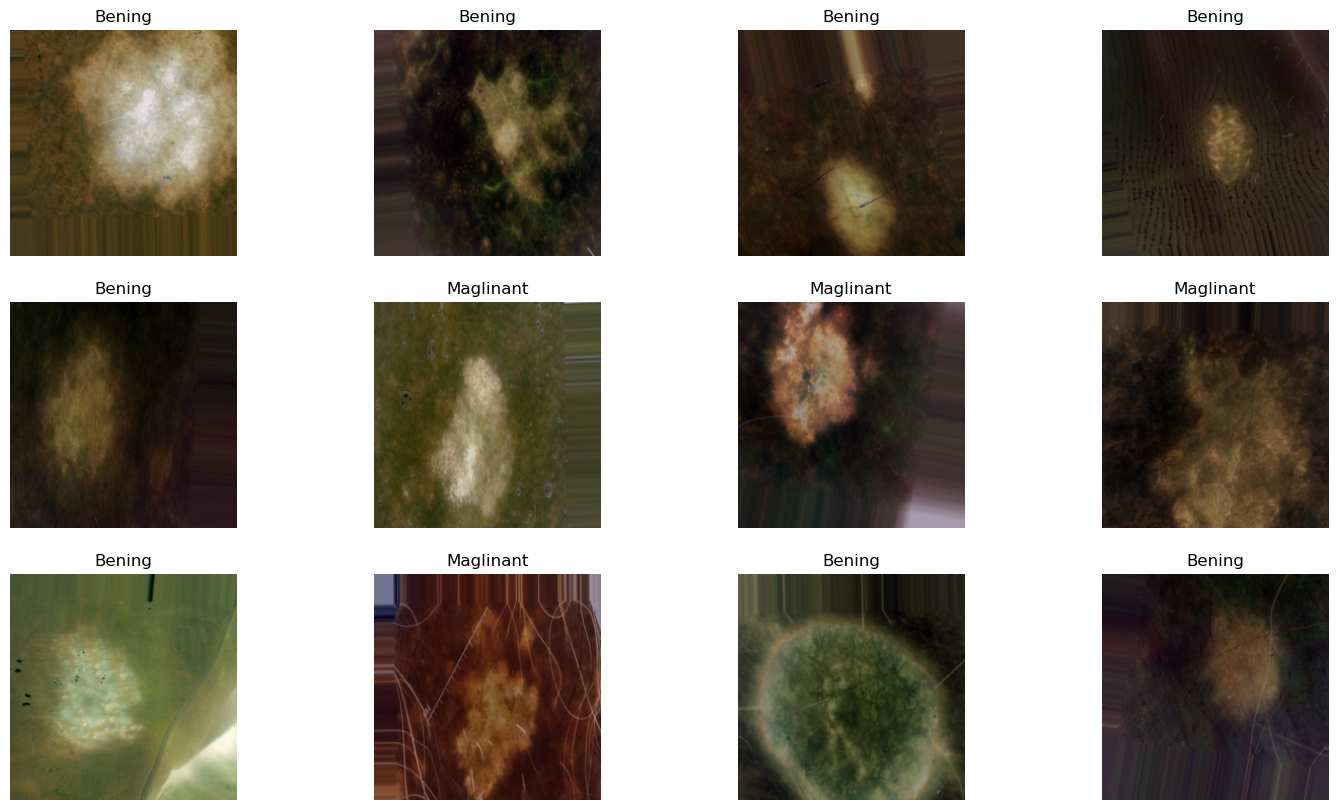

In [9]:
plt.figure(figsize=(18, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(shuffled_list1_rgb[i].astype("uint32"))
    plt.title(class_names[shuffled_list2_rgb[i]])
    plt.axis("off")
plt.show()

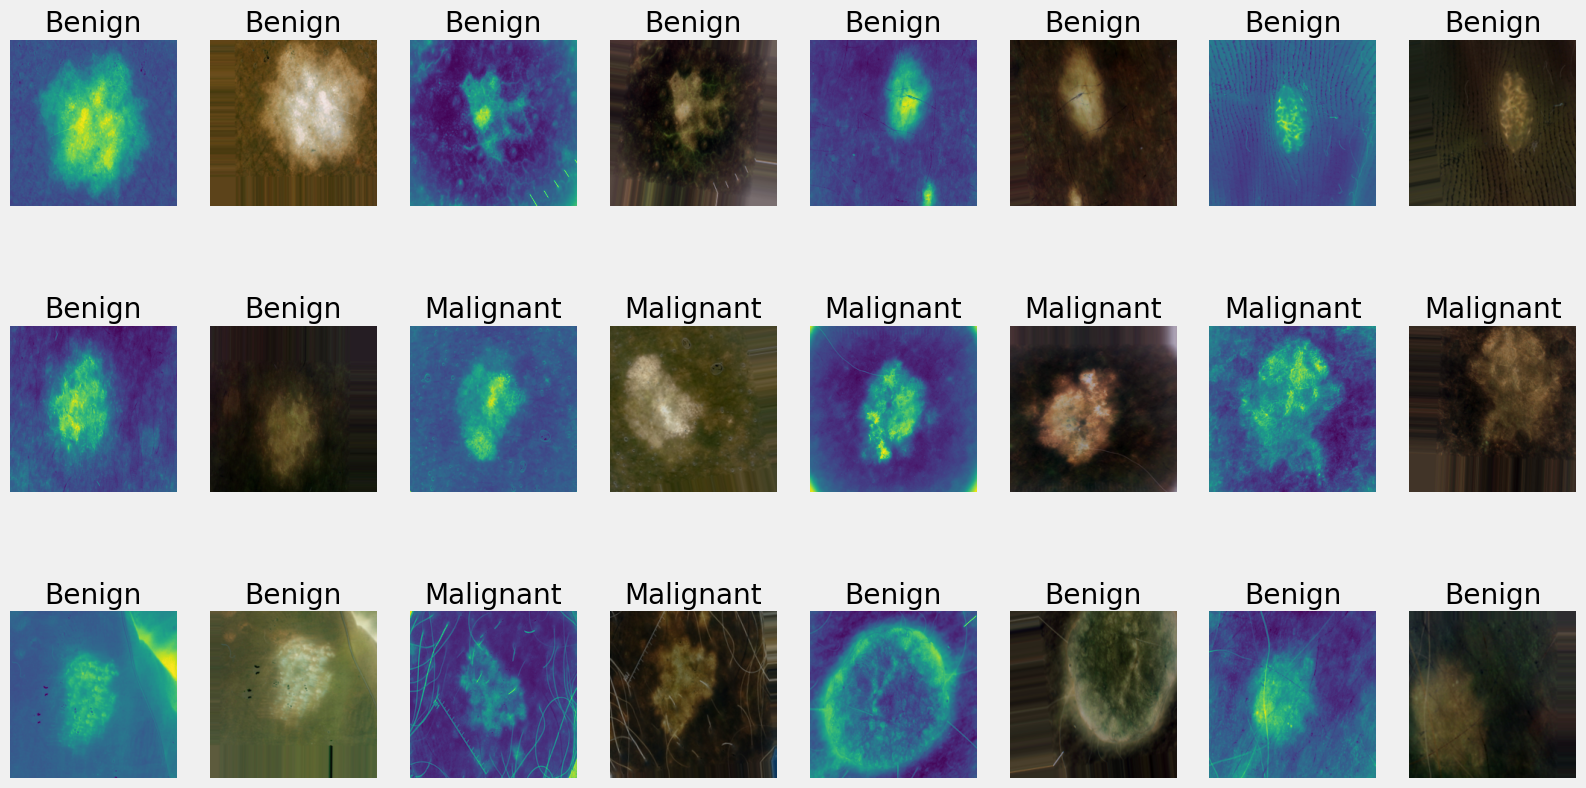

In [920]:
import random
import matplotlib.pyplot as plt

# Concatenate elementwise
combined_list = list(zip(U_train, y_train))

# Fix the seed for reproducibility
random.seed(42)

# Shuffle the combined list
random.shuffle(combined_list)

# Separate the shuffled elements
shuffled_list1, shuffled_list2 = zip(*combined_list)

# Concatenate elementwise (RGB images)
combined_list_rgb = list(zip(U_train_rgb, y_train))

# Fix the seed for reproducibility
random.seed(42)

# Shuffle the combined list (RGB images)
random.shuffle(combined_list_rgb)

# Separate the shuffled elements (RGB images)
shuffled_list1_rgb, shuffled_list2_rgb = zip(*combined_list_rgb)

class_names = ['Benign', 'Malignant']

plt.figure(figsize=(18, 10))

# Plot original images
for i in range(12):
    plt.subplot(3, 8, 2*i + 1)
    plt.imshow(shuffled_list1[i].astype("uint8"))
    plt.title(class_names[shuffled_list2[i]])
    plt.axis("off")

# Plot augmented images (RGB)
for i in range(12):
    plt.subplot(3, 8, 2*i + 2)
    plt.imshow(shuffled_list1_rgb[i].clip(0, 255).astype("uint8"))
    plt.title(class_names[shuffled_list2_rgb[i]])
    plt.axis("off")

plt.show()

In [17]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.images import DilationFiltration, ErosionFiltration, SignedDistanceFiltration
from gtda.images.preprocessing import Inverter, Padder, ImageToPointCloud

#direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
direction_list = [
    [1, 0], [0, 1], [-1, 0], [0, -1],  # Horizontal and vertical directions
    [1, 1], [-1, 1], [1, -1], [-1, -1],  # Diagonal directions
    [2, 1], [-2, 1], [2, -1], [-2, -1],  # Extended diagonal directions
]

#center_list = [
#    [13, 6],
#    [6, 13],
#    [13, 13],
#    [20, 13],
#    [13, 20],
#    [6, 6],
#    [6, 20],
#    [20, 6],
#    [20, 20],
#]

center_list = [
    [13, 6], [6, 13], [13, 13], [20, 13], [13, 20],  # Existing centers
    [6, 6], [6, 20], [20, 6], [20, 20],  # Corner centers
    [10, 10], [16, 10], [10, 16], [16, 16],  # Centered quadrant centers
]


# Creating a list of all filtration transformers
filtration_list = [
    HeightFiltration(direction=np.array(direction), n_jobs=-1)
    for direction in direction_list
] + [
    RadialFiltration(center=np.array(center), n_jobs=-1)
    for center in center_list
] + [
    DilationFiltration(n_jobs=-1)
]

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        Padder(padding=np.array([2, 2]), value=0, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Select a variety of metrics to calculate amplitudes
metric_list = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "betti", "heat", "silhouette", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

# Create the diagram generation pipelines
pipeline_list = [
    make_pipeline(*diagram_step, feature_union)
    for diagram_step in diagram_steps
]

# Create the final TDA union pipeline
tda_union = make_union(*pipeline_list, n_jobs=-1)

In [19]:
X_train_tda = tda_union.fit_transform(U_train)
X_test_tda = tda_union.fit_transform(U_test)

In [20]:
X_train_tda.shape, X_test_tda.shape

((2637, 416), (660, 416))

# RF to TDA only!

In [21]:
X_train_tda_scaled = StandardScaler().fit_transform(X_train_tda)
X_test_tda_scaled = StandardScaler().fit_transform(X_test_tda)

rf_tda = RandomForestClassifier(random_state=0)
rf_tda.fit(X_train_tda_scaled, y_train)

print(rf_tda.score(X_test_tda_scaled, y_test))

0.7681818181818182


Confusion Matrix, Without Normalization
[[294  66]
 [ 87 213]]


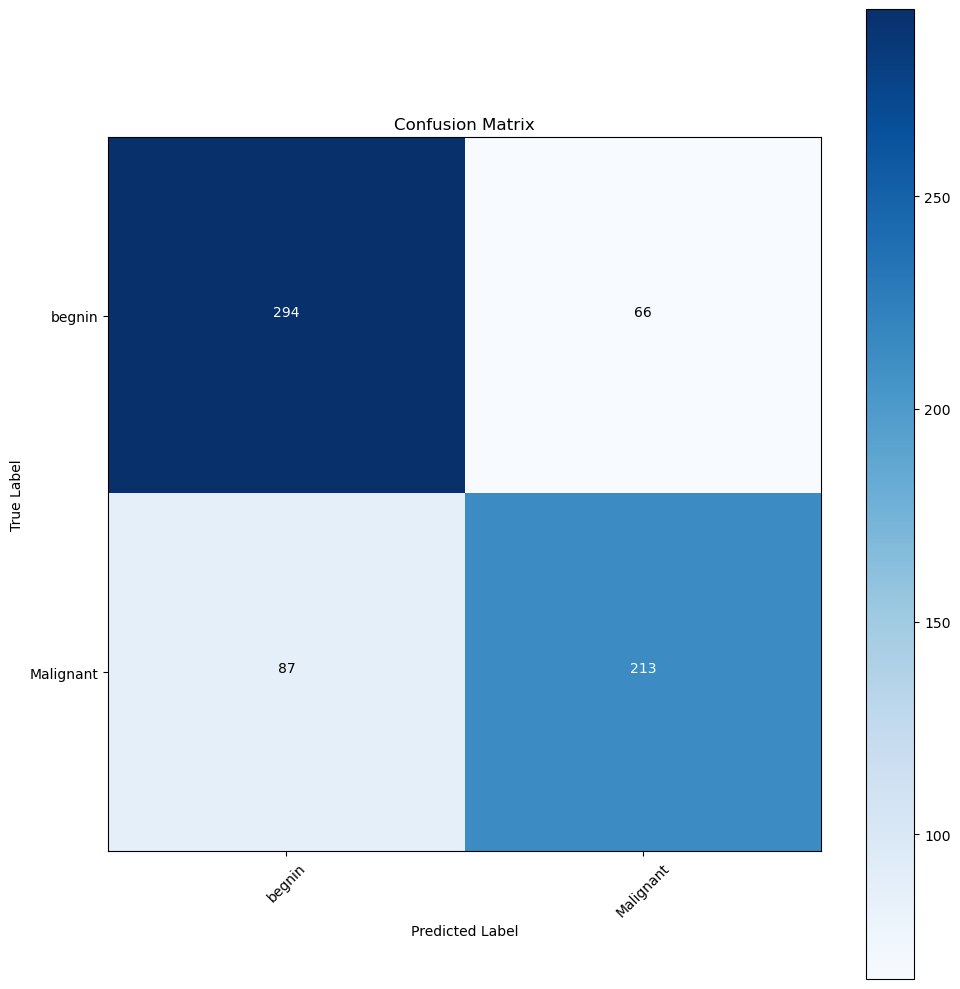

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):


    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


cm = confusion_matrix(y_test, rf_tda.predict(X_test_tda_scaled))
plot_confusion_matrix(cm= cm, classes= ["begnin", "Malignant"], title = 'Confusion Matrix')

# MLP

In [122]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Standardize the training and test data
scaler = StandardScaler()
X_train_tda_scaled = scaler.fit_transform(X_train_tda)
X_test_tda_scaled = scaler.transform(X_test_tda)

# Create and configure the MLP classifier
mlp_tda = MLPClassifier(
    hidden_layer_sizes=(100,),  # Number of neurons in the hidden layer(s)
    activation='relu',  # Activation function for the hidden layer(s)
    solver='adam',  # Optimization algorithm
    alpha=0.0001,  # L2 regularization parameter
    batch_size='auto',  # Number of samples per mini-batch
    learning_rate='constant',  # Learning rate schedule
    learning_rate_init=0.0001,  # Initial learning rate
    max_iter=200,  # Maximum number of iterations
    shuffle=True,  # Whether to shuffle the training data
    random_state=123,  # Seed for the random number generator
    tol=0.0001,  # Tolerance for optimization convergence
    verbose=False,  # Whether to print progress messages
    early_stopping=False,  # Whether to use early stopping
    validation_fraction=0.1,  # Fraction of training data used for validation
    n_iter_no_change=10,  # Maximum number of iterations with no improvement
)

# Fit the MLP classifier to the training data
mlp_tda.fit(X_train_tda_scaled, y_train)

# Evaluate the MLP classifier on the test data
score = mlp_tda.score(X_test_tda_scaled, y_test)
print("Accuracy: {:.2f}".format(score))


Accuracy: 0.77


Confusion Matrix, Without Normalization
[[273  87]
 [ 63 237]]


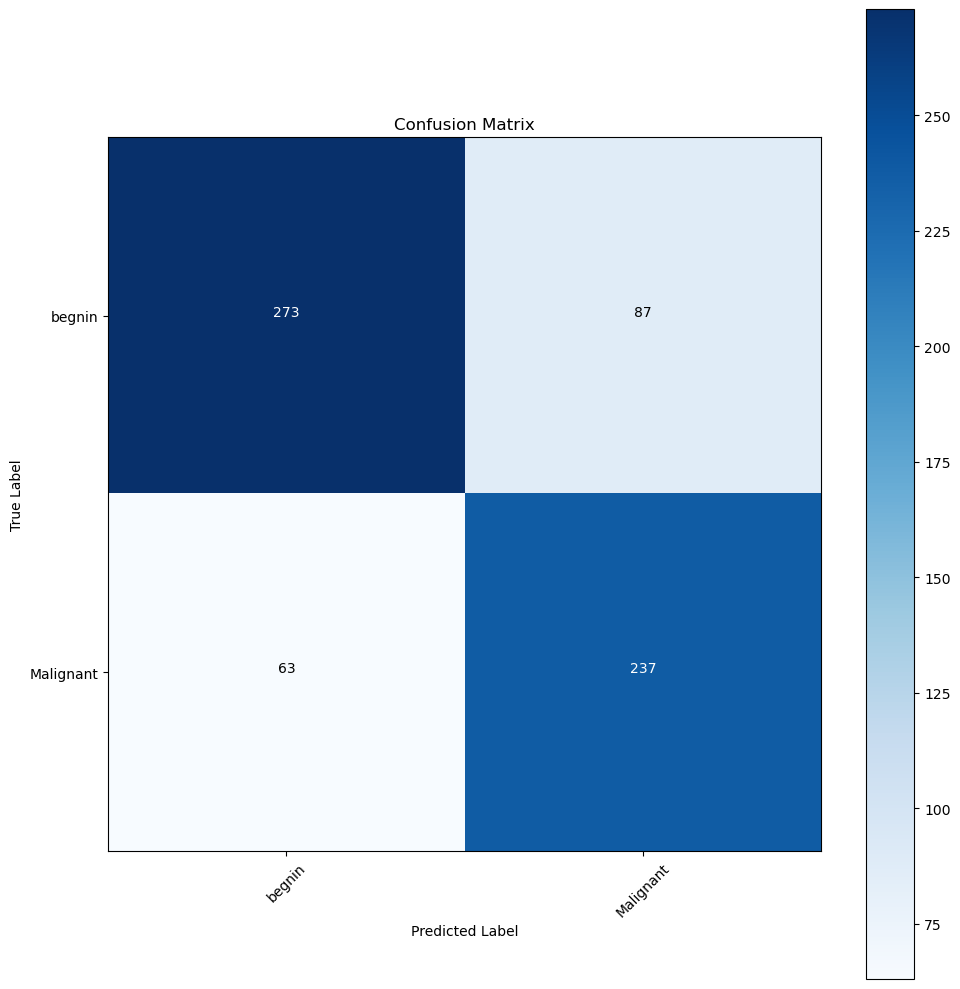

In [29]:
cm_mlp = confusion_matrix(y_test, mlp_tda.predict(X_test_tda_scaled))
plot_confusion_matrix(cm= cm_mlp, classes= ["begnin", "Malignant"], title = 'Confusion Matrix')

 By separating the calculate_histograms function into a separate module and importing it, you should be able to 
#avoid the "Can't get attribute 'calculate_histograms' on <module 'main' (built-in)>" error and successfully 
#execute the code in parallel using the ProcessPoolExecutor.

In [146]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Convert X_train and y_train to NumPy arrays
X_train_2 = np.array(X_train_tda_scaled)
y_train_2 = np.array(y_train)

X_test_2 = np.array(X_test_tda_scaled)
y_test_2 = np.array(y_test)


# Define the Neural Network model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train_2.shape[1],)),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_2, y_train_2, epochs=30, batch_size=128)

# Evaluate the model
accuracy = model.evaluate(X_test_2, y_test_2)[1]
print("Accuracy: {:.2f}".format(accuracy))



Epoch 1/30
21/21 [==============================] - 0s 2ms/step - loss: 0.6427 - accuracy: 0.6841
Epoch 2/30
21/21 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7308
Epoch 3/30
21/21 [==============================] - 0s 2ms/step - loss: 0.5279 - accuracy: 0.7421
Epoch 4/30
21/21 [==============================] - 0s 2ms/step - loss: 0.5171 - accuracy: 0.7478
Epoch 5/30
21/21 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.7630
Epoch 6/30
21/21 [==============================] - 0s 2ms/step - loss: 0.5016 - accuracy: 0.7527
Epoch 7/30
21/21 [==============================] - 0s 2ms/step - loss: 0.4867 - accuracy: 0.7653
Epoch 8/30
21/21 [==============================] - 0s 2ms/step - loss: 0.4892 - accuracy: 0.7717
Epoch 9/30
21/21 [==============================] - 0s 2ms/step - loss: 0.4757 - accuracy: 0.7691
Epoch 10/30
21/21 [==============================] - 0s 2ms/step - loss: 0.4739 - accuracy: 0.7854
Epoch 11/30
21/21 [

# GEO

In [30]:
n = 200
XX_train_geo = np.zeros((len(U_train), 12*n))
i = 0
L = np.linspace(0,1,n)
for i in range(len(U_train)):
    print(i)
    UU = U_train_rgb[i]
    U1= UU[:,:,0]
    U2= UU[:,:,1]
    U3= UU[:,:,2]
    U_gray = U_train[i]
    L1 = np.linspace(np.min(U1), np.max(U1), n)
    L2 = np.linspace(np.min(U2), np.max(U2), n)
    L3 = np.linspace(np.min(U3), np.max(U3), n)
    L_g = np.linspace(np.min(U_gray), np.max(U_gray), n)
    for k in range(n):
        XX_train_geo[i][k] = np.sum(U1 >= L1[k]) 
        XX_train_geo[i][k+n] = np.sum(U2 >= L2[k]) 
        XX_train_geo[i][k+2*n] = np.sum(U3 >= L3[k]) 
        XX_train_geo[i][k+3*n] = np.sum(U_gray >= L_g[k]) 
        XX_train_geo[i][k+4*n] = Perimetre_Hermine(U1, L1[k]) 
        XX_train_geo[i][k+5*n] = Perimetre_Hermine(U2, L2[k])
        XX_train_geo[i][k+6*n] = Perimetre_Hermine(U3, L3[k])
        XX_train_geo[i][k+7*n] = Perimetre_Hermine(U_gray, L_g[k])
        XX_train_geo[i][k+8*n] = Euler(U1 >= L1[k]) 
        XX_train_geo[i][k+9*n] = Euler(U2 >= L2[k]) 
        XX_train_geo[i][k+10*n] = Euler(U3 >= L3[k]) 
        XX_train_geo[i][k+11*n] = Euler(U_gray >= L_g[k]) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [31]:
n = 200
XX_test_geo = np.zeros((len(U_test), 12*n))
for i in range(len(U_test)):
    print(i)
    UU = U_test_rgb[i]
    U1= UU[:,:,0]
    U2= UU[:,:,1]
    U3= UU[:,:,2]
    U_gray = U_test[i]
    L1 = np.linspace(np.min(U1), np.max(U1), n)
    L2 = np.linspace(np.min(U2), np.max(U2), n)
    L3 = np.linspace(np.min(U3), np.max(U3), n)
    L_g = np.linspace(np.min(U_gray), np.max(U_gray), n)
    for k in range(n):
        XX_test_geo[i][k] = np.sum(U1 >= L1[k]) 
        XX_test_geo[i][k+n] = np.sum(U2 >= L2[k]) 
        XX_test_geo[i][k+2*n] = np.sum(U3 >= L3[k]) 
        XX_test_geo[i][k+3*n] = np.sum(U_gray >= L_g[k]) 
        XX_test_geo[i][k+4*n] = Perimetre_Hermine(U1, L1[k]) 
        XX_test_geo[i][k+5*n] = Perimetre_Hermine(U2, L2[k])
        XX_test_geo[i][k+6*n] = Perimetre_Hermine(U3, L3[k])
        XX_test_geo[i][k+7*n] = Perimetre_Hermine(U_gray, L_g[k])
        XX_test_geo[i][k+8*n] = Euler(U1 >= L1[k]) 
        XX_test_geo[i][k+9*n] = Euler(U2 >= L2[k]) 
        XX_test_geo[i][k+10*n] = Euler(U3 >= L3[k]) 
        XX_test_geo[i][k+11*n] = Euler(U_gray >= L_g[k]) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
# Standardize the training and test data
scaler = StandardScaler()
XX_train_geo_scaled = scaler.fit_transform(XX_train_geo)
XX_test_geo_scaled = scaler.transform(XX_test_geo)

# Random forest

In [38]:
rf_geo = RandomForestClassifier(random_state=0)
rf_geo.fit(XX_train_geo_scaled, y_train)

print(rf_geo.score(XX_test_geo_scaled, y_test))

0.8136363636363636


In [116]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


# MLP

In [117]:
# Create and configure the MLP classifier
mlp_geo = MLPClassifier(
    hidden_layer_sizes=(100,),  # Number of neurons in the hidden layer(s)
    activation='tanh',  # Activation function for the hidden layer(s)
    solver='adam',  # Optimization algorithm
    alpha=0.0001,  # L2 regularization parameter
    batch_size='auto',  # Number of samples per mini-batch
    learning_rate='constant',  # Learning rate schedule
    learning_rate_init=0.001,  # Initial learning rate
    max_iter=200,  # Maximum number of iterations
    shuffle=True,  # Whether to shuffle the training data
    random_state=0,  # Seed for the random number generator
    tol=0.001,  # Tolerance for optimization convergence
    verbose=False,  # Whether to print progress messages
    early_stopping=False,  # Whether to use early stopping
    validation_fraction=0.1,  # Fraction of training data used for validation
    n_iter_no_change=10,  # Maximum number of iterations with no improvement
)

# Fit the MLP classifier to the training data
mlp_geo.fit(XX_train_geo_scaled, y_train)

# Evaluate the MLP classifier on the test data
score = mlp_geo.score(XX_test_geo_scaled, y_test)
print("Accuracy: {:.2f}".format(score))

Accuracy: 0.80


Confusion Matrix, Without Normalization
[[297  63]
 [ 55 245]]


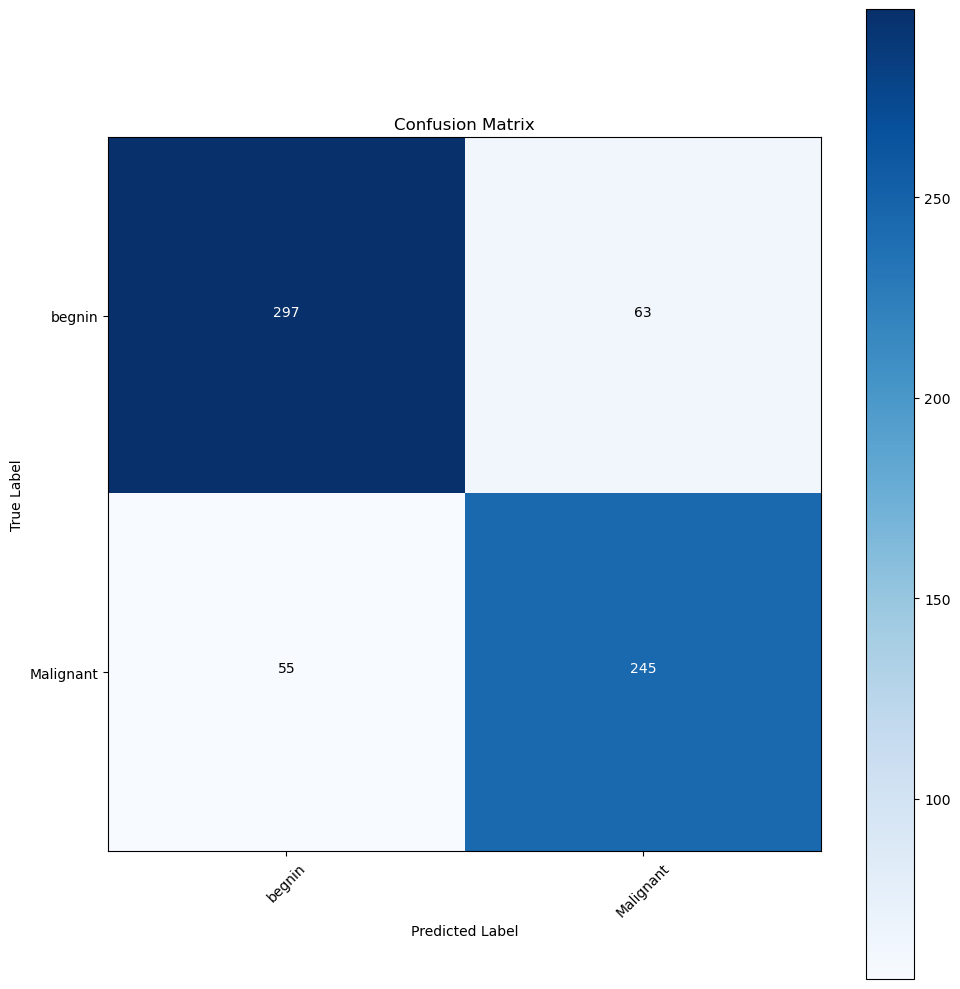

In [30]:
cm_mlp_geo = confusion_matrix(y_test, mlp_geo.predict(XX_test_geo_scaled))
plot_confusion_matrix(cm= cm_mlp_geo, classes= ["begnin", "Malignant"], title = 'Confusion Matrix')

# Deep learning

Accuracy: 0.82
21/21 [==============================] - 0s 1ms/step


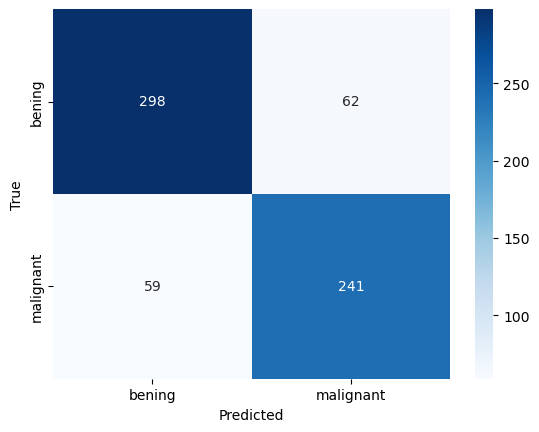

In [114]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the data to NumPy arrays
XX_train_geo_scaled = np.array(XX_train_geo_scaled)
XX_test_geo_scaled = np.array(XX_test_geo_scaled)

# Encode the target variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Perform one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

# Create and configure the MLP model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(12*n,)))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model to the training data
model.fit(XX_train_geo_scaled, y_train_onehot, epochs=200, batch_size=128, verbose=0)

# Evaluate the model on the test data
score = model.evaluate(XX_test_geo_scaled, y_test_onehot, verbose=0)
print("Accuracy: {:.2f}".format(score[1]))

# Compute and plot the confusion matrix
y_pred_onehot = model.predict(XX_test_geo_scaled)
y_pred = np.argmax(y_pred_onehot, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)
#cm = confusion_matrix(y_true, y_pred)
cm_dl_geo = confusion_matrix(y_test,y_pred)
#plot_confusion_matrix(cm= cm_mlp_geo, classes= ["begnin", "Malignant"], title = 'Confusion Matrix')

sns.heatmap(cm_dl_geo, annot=True, fmt='d', xticklabels= ['bening', 'malignant'], yticklabels= ['bening', 'malignant'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [110]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 256)               614656    
                                                                 
 dense_107 (Dense)           (None, 2)                 514       
                                                                 
Total params: 615,170
Trainable params: 615,170
Non-trainable params: 0
_________________________________________________________________


# SVM

In [111]:
classifier_geo = SVC(kernel='rbf', random_state = 0)
classifier_geo.fit(XX_train_geo_scaled, y_train)
y_pred_geo = classifier_geo.predict(XX_test_geo_scaled)
cm = confusion_matrix(y_test,y_pred_geo)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.7924242424242425


# Transfer Learning with Convolutional Neural Networks (CNNs):

The pre-trained VGG16 model is used as the base model, and a new classifier is added on top of it. The pre-trained layers are frozen to retain their weights while training the new classifier. We can adjust the architecture and parameters according to our specific requirements.

In [78]:
import numpy as np
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

# Resize the images to match the input shape of the pre-trained model
resized_shape = (224, 224)
XX_train_geo_resized = np.array([resize(img, resized_shape, preserve_range=True) for img in XX_train_geo_scaled])
XX_test_geo_resized = np.array([resize(img, resized_shape, preserve_range=True) for img in XX_test_geo_scaled])

# Repeat the single channel along the last axis to create a three-channel image
XX_train_geo_resized = np.repeat(XX_train_geo_resized[..., np.newaxis], 3, axis=-1)
XX_test_geo_resized = np.repeat(XX_test_geo_resized[..., np.newaxis], 3, axis=-1)

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(resized_shape[0], resized_shape[1], 3))

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Freeze the pre-trained layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Train the model
history = model.fit(XX_train_geo_resized, y_train_categorical, batch_size=32, epochs=10, validation_data=(XX_test_geo_resized, y_test_categorical))

# Evaluate the model on the test data
score = model.evaluate(XX_test_geo_resized, y_test_categorical)
print("Accuracy: {:.2f}".format(score[1]))

# Calculate the mean accuracy during training
mean_train_accuracy = np.mean(history.history['accuracy'])
print("Mean Train Accuracy: {:.2f}".format(mean_train_accuracy))

# Calculate the mean accuracy on the test data
mean_test_accuracy = np.mean(history.history['val_accuracy'])
print("Mean Test Accuracy: {:.2f}".format(mean_test_accuracy))


Epoch 1/10
83/83 [==============================] - 353s 4s/step - loss: 0.7870 - accuracy: 0.5245 - val_loss: 0.6918 - val_accuracy: 0.5455
Epoch 2/10
83/83 [==============================] - 357s 4s/step - loss: 0.6910 - accuracy: 0.5461 - val_loss: 0.6903 - val_accuracy: 0.5455
Epoch 3/10
83/83 [==============================] - 357s 4s/step - loss: 0.6900 - accuracy: 0.5461 - val_loss: 0.6897 - val_accuracy: 0.5455
Epoch 4/10
83/83 [==============================] - 357s 4s/step - loss: 0.6895 - accuracy: 0.5461 - val_loss: 0.6893 - val_accuracy: 0.5455
Epoch 5/10
83/83 [==============================] - 355s 4s/step - loss: 0.6892 - accuracy: 0.5461 - val_loss: 0.6891 - val_accuracy: 0.5455
Epoch 6/10
83/83 [==============================] - 353s 4s/step - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6891 - val_accuracy: 0.5455
Epoch 7/10
83/83 [==============================] - 351s 4s/step - loss: 0.6889 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 8/10
83

# Transfer learning EfficientNetB3

In [83]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

# Resize the images to match the input shape of the pre-trained model
resized_shape = (224, 224)
XX_train_geo_resized = np.array([resize(img, resized_shape, preserve_range=True) for img in XX_train_geo_scaled])
XX_test_geo_resized = np.array([resize(img, resized_shape, preserve_range=True) for img in XX_test_geo_scaled])

# Repeat the single channel along the last axis to create a three-channel image
XX_train_geo_resized = np.repeat(XX_train_geo_resized[..., np.newaxis], 3, axis=-1)
XX_test_geo_resized = np.repeat(XX_test_geo_resized[..., np.newaxis], 3, axis=-1)

# Load the pre-trained EfficientNetB3 model without the top layers
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(resized_shape[0], resized_shape[1], 3))

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Freeze the pre-trained layers to prevent them from being updated during training
base_model.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Train the model
history = model.fit(XX_train_geo_resized, y_train_categorical, batch_size=32, epochs=2, validation_data=(XX_test_geo_resized, y_test_categorical))

# Evaluate the model on the test data
score = model.evaluate(XX_test_geo_resized, y_test_categorical)
print("Accuracy: {:.2f}".format(score[1]))

# Calculate the mean accuracy during training
mean_train_accuracy = np.mean(history.history['accuracy'])
print("Mean Train Accuracy: {:.2f}".format(mean_train_accuracy))

# Calculate the mean accuracy on the test data
mean_test_accuracy = np.mean(history.history['val_accuracy'])
print("Mean Test Accuracy: {:.2f}".format(mean_test_accuracy))


Epoch 1/2
83/83 [==============================] - 68s 772ms/step - loss: 2.3374 - accuracy: 0.5434 - val_loss: 0.6573 - val_accuracy: 0.6152
Epoch 2/2
21/21 [==============================] - 13s 613ms/step - loss: 0.6985 - accuracy: 0.5909
Accuracy: 0.59
Mean Train Accuracy: 0.56
Mean Test Accuracy: 0.60


# LSTM model 

In [48]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np

# Reshape the input data
XX_train_geo_reshaped = np.reshape(XX_train_geo_scaled, (XX_train_geo_scaled.shape[0], 1, XX_train_geo_scaled.shape[1]))
XX_test_geo_reshaped = np.reshape(XX_test_geo_scaled, (XX_test_geo_scaled.shape[0], 1, XX_test_geo_scaled.shape[1]))

# Encode the target variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Perform one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

# Create and configure the LSTM model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(1, XX_train_geo_scaled.shape[1])))
model.add(Dense(2, activation='softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the LSTM model to the training data
model.fit(XX_train_geo_reshaped, y_train_onehot, epochs=220, batch_size=32, verbose=0)

# Evaluate the LSTM model on the test data
score = model.evaluate(XX_test_geo_reshaped, y_test_onehot, verbose=0)
print("Accuracy: {:.2f}".format(score[1]))


2023-06-07 12:20:46.596369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Accuracy: 0.83


# TDA + GEO

In [49]:
X_train_tda.shape, XX_train_geo.shape, X_test_tda.shape, XX_test_geo.shape

((2637, 416), (2637, 2400), (660, 416), (660, 2400))

In [50]:
X_train_conj = np.concatenate((X_train_tda, XX_train_geo), axis=1)
X_test_conj = np.concatenate((X_test_tda, XX_test_geo), axis=1)

In [51]:
X_train_conj.shape, X_test_conj.shape

((2637, 2816), (660, 2816))

In [52]:
X_train_conj_scaled = scaler.fit_transform(X_train_conj)
X_test_conj_scaled = scaler.fit_transform(X_test_conj)

In [53]:
type(X_train_conj_scaled)

numpy.ndarray

In [120]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np

# Reshape the input data
X_train_conj_reshaped = np.reshape(X_train_conj_scaled, (X_train_conj_scaled.shape[0], 1, X_train_conj_scaled.shape[1]))
X_test_conj_reshaped = np.reshape(X_test_conj_scaled, (X_test_conj_scaled.shape[0], 1, X_test_conj_scaled.shape[1]))

# Create and configure the LSTM model
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(1, X_train_conj_scaled.shape[1])))
model.add(Dense(2, activation='softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the LSTM model to the training data
model.fit(X_train_conj_reshaped, y_train_onehot, epochs=100, batch_size=32, verbose=0)

# Evaluate the LSTM model on the test data
score = model.evaluate(X_test_conj_reshaped, y_test_onehot, verbose=0)
print("Accuracy: {:.2f}".format(score[1]))

Accuracy: 0.84


In [104]:
# Reshape the input data
# Reshape the input data
from keras.layers import LSTM, Dense, Dropout

X_train_conj_reshaped = np.reshape(X_train_conj_scaled, (X_train_conj_scaled.shape[0], 1, X_train_conj_scaled.shape[1]))
X_test_conj_reshaped = np.reshape(X_test_conj_scaled, (X_test_conj_scaled.shape[0], 1, X_test_conj_scaled.shape[1]))


lstm_units = 256 # 128
dropout_rate = 0.6 #0.6
num_classes = 2
y_train_onehot_2 = np.eye(num_classes)[y_train]
y_test_onehot_2 = np.eye(num_classes)[y_test]

# Create and configure the LSTM model
model = Sequential()
model.add(LSTM(lstm_units, activation='tanh', input_shape=(1, X_train_conj_scaled.shape[1]), return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the LSTM model to the training data
model.fit(X_train_conj_reshaped, y_train_onehot_2, epochs=100, batch_size=128, verbose=0)

# Evaluate the LSTM model on the test data
score = model.evaluate(X_test_conj_reshaped, y_test_onehot_2, verbose=0)
print("Accuracy: {:.2f}".format(score[1]))

Accuracy: 0.82


In [149]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Preprocess the data
scaler = StandardScaler()
X_train_conj_scaled = scaler.fit_transform(X_train_conj)
X_test_conj_scaled = scaler.transform(X_test_conj)

X_train_conj_reshaped = np.reshape(X_train_conj_scaled, (X_train_conj_scaled.shape[0], 1, X_train_conj_scaled.shape[1]))
X_test_conj_reshaped = np.reshape(X_test_conj_scaled, (X_test_conj_scaled.shape[0], 1, X_test_conj_scaled.shape[1]))

# Convert labels to one-hot encoding
num_classes = 2
#y_train_onehot = np.eye(num_classes)[y_train]
#y_test_onehot = np.eye(num_classes)[y_test]

# Define the function to create the LSTM model
def create_model(lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(1, X_train_conj_scaled.shape[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create and configure the LSTM model
model = KerasClassifier(build_fn=create_model)

# Perform hyperparameter tuning
param_grid = {
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.6],
    'batch_size': [128],
    'epochs': [200]#, 200, 300]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_conj_reshaped, y_train_onehot, verbose=1)

# Get the best model and evaluate on the test data
best_model = grid_result.best_estimator_
accuracy = best_model.score(X_test_conj_reshaped, y_test_onehot)
print("Accuracy: {:.2f}".format(accuracy))


Epoch 1/200
14/14 [==============================] - 2s 6ms/step - loss: 0.6687 - accuracy: 0.6320
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 0.6199 - accuracy: 0.7292
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5864 - accuracy: 0.7321
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.7497
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5365 - accuracy: 0.7787
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5171 - accuracy: 0.7844
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4968 - accuracy: 0.7907
Epoch 8/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4832 - accuracy: 0.7969
Epoch 9/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4714 - accuracy: 0.8026
Epoch 10/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4604 - accuracy: 0.8163
Epoch 11/

14/14 [==============================] - 0s 6ms/step - loss: 0.1155 - accuracy: 0.9721
Epoch 84/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1299 - accuracy: 0.9590
Epoch 85/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1162 - accuracy: 0.9670
Epoch 86/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1198 - accuracy: 0.9596
Epoch 87/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1047 - accuracy: 0.9710
Epoch 88/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1129 - accuracy: 0.9659
Epoch 89/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1171 - accuracy: 0.9579
Epoch 90/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1089 - accuracy: 0.9636
Epoch 91/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1077 - accuracy: 0.9704
Epoch 92/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1065 - accuracy: 0.9704
Epoch 93/200


14/14 [==============================] - 0s 6ms/step - loss: 0.2622 - accuracy: 0.8936
Epoch 45/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2557 - accuracy: 0.9010
Epoch 46/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2527 - accuracy: 0.9016
Epoch 47/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2489 - accuracy: 0.9056
Epoch 48/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2381 - accuracy: 0.9124
Epoch 49/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2370 - accuracy: 0.9084
Epoch 50/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2379 - accuracy: 0.9101
Epoch 51/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2340 - accuracy: 0.9039
Epoch 52/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2313 - accuracy: 0.9118
Epoch 53/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2237 - accuracy: 0.9164
Epoch 54/200


14/14 [==============================] - 0s 7ms/step - loss: 0.4647 - accuracy: 0.8402
Epoch 6/200
14/14 [==============================] - 0s 7ms/step - loss: 0.4402 - accuracy: 0.8430
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4258 - accuracy: 0.8447
Epoch 8/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4079 - accuracy: 0.8458
Epoch 9/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3920 - accuracy: 0.8595
Epoch 10/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3792 - accuracy: 0.8538
Epoch 11/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3677 - accuracy: 0.8635
Epoch 12/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3650 - accuracy: 0.8595
Epoch 13/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3533 - accuracy: 0.8663
Epoch 14/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3430 - accuracy: 0.8663
Epoch 15/200
14/1

14/14 [==============================] - 0s 6ms/step - loss: 0.1098 - accuracy: 0.9659
Epoch 88/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 0.9676
Epoch 89/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0979 - accuracy: 0.9681
Epoch 90/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1047 - accuracy: 0.9670
Epoch 91/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0957 - accuracy: 0.9693
Epoch 92/200
14/14 [==============================] - 0s 6ms/step - loss: 0.1004 - accuracy: 0.9625
Epoch 93/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0943 - accuracy: 0.9738
Epoch 94/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9647
Epoch 95/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0946 - accuracy: 0.9704
Epoch 96/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0877 - accuracy: 0.9772
Epoch 97/200


Epoch 49/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1262 - accuracy: 0.9642
Epoch 50/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1200 - accuracy: 0.9619
Epoch 51/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.9613
Epoch 52/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1105 - accuracy: 0.9664
Epoch 53/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1029 - accuracy: 0.9704
Epoch 54/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0979 - accuracy: 0.9681
Epoch 55/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0994 - accuracy: 0.9733
Epoch 56/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1011 - accuracy: 0.9676
Epoch 57/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0969 - accuracy: 0.9687
Epoch 58/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0901 - accuracy: 0.9704


14/14 [==============================] - 0s 9ms/step - loss: 0.4374 - accuracy: 0.8134
Epoch 11/200
14/14 [==============================] - 0s 9ms/step - loss: 0.4305 - accuracy: 0.8077
Epoch 12/200
14/14 [==============================] - 0s 9ms/step - loss: 0.4161 - accuracy: 0.8157
Epoch 13/200
14/14 [==============================] - 0s 9ms/step - loss: 0.4049 - accuracy: 0.8220
Epoch 14/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3901 - accuracy: 0.8265
Epoch 15/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3786 - accuracy: 0.8333
Epoch 16/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3714 - accuracy: 0.8390
Epoch 17/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3572 - accuracy: 0.8470
Epoch 18/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3484 - accuracy: 0.8544
Epoch 19/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3340 - accuracy: 0.8458
Epoch 20/200


14/14 [==============================] - 0s 9ms/step - loss: 0.0416 - accuracy: 0.9898
Epoch 93/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0511 - accuracy: 0.9846
Epoch 94/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0444 - accuracy: 0.9886
Epoch 95/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0471 - accuracy: 0.9829
Epoch 96/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0359 - accuracy: 0.9926
Epoch 97/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0361 - accuracy: 0.9886
Epoch 98/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0328 - accuracy: 0.9920
Epoch 99/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0395 - accuracy: 0.9898
Epoch 100/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0359 - accuracy: 0.9920
Epoch 101/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0393 - accuracy: 0.9920
Epoch 102/2

Epoch 54/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0905 - accuracy: 0.9716
Epoch 55/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0999 - accuracy: 0.9687
Epoch 56/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0886 - accuracy: 0.9716
Epoch 57/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0866 - accuracy: 0.9727
Epoch 58/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0890 - accuracy: 0.9670
Epoch 59/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0868 - accuracy: 0.9733
Epoch 60/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0823 - accuracy: 0.9767
Epoch 61/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0777 - accuracy: 0.9767
Epoch 62/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0667 - accuracy: 0.9824
Epoch 63/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0732 - accuracy: 0.9761


14/14 [==============================] - 0s 17ms/step - loss: 0.2865 - accuracy: 0.8885
Epoch 16/200
14/14 [==============================] - 0s 17ms/step - loss: 0.2766 - accuracy: 0.8931
Epoch 17/200
14/14 [==============================] - 0s 16ms/step - loss: 0.2559 - accuracy: 0.9113
Epoch 18/200
14/14 [==============================] - 0s 17ms/step - loss: 0.2518 - accuracy: 0.9084
Epoch 19/200
14/14 [==============================] - 0s 16ms/step - loss: 0.2381 - accuracy: 0.9096
Epoch 20/200
14/14 [==============================] - 0s 16ms/step - loss: 0.2303 - accuracy: 0.9175
Epoch 21/200
14/14 [==============================] - 0s 17ms/step - loss: 0.2170 - accuracy: 0.9175
Epoch 22/200
14/14 [==============================] - 0s 16ms/step - loss: 0.2093 - accuracy: 0.9238
Epoch 23/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1955 - accuracy: 0.9278
Epoch 24/200
14/14 [==============================] - 0s 17ms/step - loss: 0.1890 - accuracy: 0.9300
Epo

14/14 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 0.9983
Epoch 177/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0068 - accuracy: 0.9989
Epoch 178/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0054 - accuracy: 0.9989
Epoch 179/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 0.9994
Epoch 180/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 181/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0060 - accuracy: 0.9972
Epoch 182/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0064 - accuracy: 0.9983
Epoch 183/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0069 - accuracy: 0.9977
Epoch 184/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 0.9977
Epoch 185/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0039 - accuracy: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0134 - accuracy: 0.9972
Epoch 137/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0155 - accuracy: 0.9949
Epoch 138/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0125 - accuracy: 0.9966
Epoch 139/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0125 - accuracy: 0.9954
Epoch 140/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0134 - accuracy: 0.9954
Epoch 141/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0136 - accuracy: 0.9966
Epoch 142/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0243 - accuracy: 0.9926
Epoch 143/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0135 - accuracy: 0.9966
Epoch 144/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 145/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0120 - accuracy: 0

14/14 [==============================] - 0s 16ms/step - loss: 0.0080 - accuracy: 0.9983
Epoch 97/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0064 - accuracy: 0.9994
Epoch 98/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0098 - accuracy: 0.9972
Epoch 99/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0082 - accuracy: 0.9983
Epoch 100/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0109 - accuracy: 0.9977
Epoch 101/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0067 - accuracy: 0.9994
Epoch 102/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 0.9989
Epoch 103/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0066 - accuracy: 0.9983
Epoch 104/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0083 - accuracy: 0.9989
Epoch 105/200
14/14 [==============================] - 0s 16ms/step - loss: 0.0046 - accuracy: 0.99

21/21 [==============================] - 0s 9ms/step - loss: 0.1067 - accuracy: 0.9628
Epoch 57/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1064 - accuracy: 0.9628
Epoch 58/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1052 - accuracy: 0.9628
Epoch 59/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1068 - accuracy: 0.9537
Epoch 60/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0957 - accuracy: 0.9625
Epoch 61/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.9670
Epoch 62/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0862 - accuracy: 0.9719
Epoch 63/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0922 - accuracy: 0.9659
Epoch 64/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0842 - accuracy: 0.9735
Epoch 65/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0790 - accuracy: 0.9761
Epoch 66/200


In [57]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

# Reshape the input data
X_train_conj_reshaped = np.reshape(X_train_conj_scaled, (X_train_conj_scaled.shape[0], 1, X_train_conj_scaled.shape[1]))
X_test_conj_reshaped = np.reshape(X_test_conj_scaled, (X_test_conj_scaled.shape[0], 1, X_test_conj_scaled.shape[1]))

# Create and configure the LSTM model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(1, X_train_conj_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the LSTM model to the training data
model.fit(X_train_conj_reshaped, y_train_onehot, epochs=220, batch_size=32, verbose=0)

# Evaluate the LSTM model on the test data
score = model.evaluate(X_test_conj_reshaped, y_test_onehot, verbose=0)
print("Accuracy: {:.2f}".format(score[1]))


Accuracy: 0.80


# RF

In [62]:
rf_tgeo = RandomForestClassifier(random_state=0)
rf_tgeo.fit(X_train_conj_scaled, y_train)

print(rf_tgeo.score(X_test_conj_scaled, y_test))

0.8090909090909091


# XGBoost

In [101]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=0)

# Train the classifier
xgb_classifier.fit(X_train_conj_scaled, y_train)

# Predict on the test data
y_pred = xgb_classifier.predict(X_test_conj_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.81


In [161]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3)
grid_search.fit(X_train_conj_scaled, y_train)

# Get the best model and evaluate on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_conj_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.83


In [162]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [471]:
X_train_conj_scaled.shape[1], len(y_test)

(2816, 660)

In [347]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Convert X_train and y_train to NumPy arrays
X_train = np.array(X_train_conj_scaled)
y_train = np.array(y_train)

X_test = np.array(X_test_conj_scaled)
y_test = np.array(y_test)


#import tensorflow as tf
#tf.random.set_seed(123)

# Define the Neural Network model
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.1, seed= 123),
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=128)

# Save the weights
model.save_weights('model_weights.h5')

# Load de model weights
#model.load_weights('model_weights_85.h5')

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy: {:.2f}".format(accuracy))



Epoch 1/30
21/21 [==============================] - 0s 7ms/step - loss: 0.6718 - accuracy: 0.6985
Epoch 2/30
21/21 [==============================] - 0s 7ms/step - loss: 0.4546 - accuracy: 0.7819
Epoch 3/30
21/21 [==============================] - 0s 7ms/step - loss: 0.4108 - accuracy: 0.8062
Epoch 4/30
21/21 [==============================] - 0s 7ms/step - loss: 0.3674 - accuracy: 0.8320
Epoch 5/30
21/21 [==============================] - 0s 7ms/step - loss: 0.3414 - accuracy: 0.8419
Epoch 6/30
21/21 [==============================] - 0s 7ms/step - loss: 0.3157 - accuracy: 0.8578
Epoch 7/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2912 - accuracy: 0.8752
Epoch 8/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.8775
Epoch 9/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.8878
Epoch 10/30
21/21 [==============================] - 0s 7ms/step - loss: 0.2284 - accuracy: 0.9075
Epoch 11/30
21/21 [

In [896]:
def plot_training(hist, title=None):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the plot as a PDF file
    #plt.savefig('training_history_'+title+'.pdf')
     plt.savefig('training_history_{}.pdf'.format(title))
    # Show the plot
    plt.show()


In [473]:
X_train = np.array(X_train_conj_scaled)
y_train = np.array(y_train)

X_test = np.array(X_test_conj_scaled)
y_test = np.array(y_test)

In [651]:
from sklearn.model_selection import train_test_split
# Get splitted data
X_valid, X_test2, y_valid, y_test2 = train_test_split(X_test, y_test,  train_size= 0.8, shuffle= True, random_state= 123, stratify= y_test)
    


In [728]:
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers 

# Create a new model with the same architecture
new_model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    #BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.1), activity_regularizer= regularizers.l1(0.001),
                bias_regularizer= regularizers.l1(0.001), activation='tanh'),
    #BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    keras.layers.Dropout(0.1, seed= 123),
    keras.layers.Dense(1, activation='sigmoid')
])


# Load the pre-trained weights
new_model.load_weights('model_weights_85.h5')

# Load the pre-trained weights for specific layers
#new_model.load_weights('model_weights_85.h5'), by_name=True, skip_mismatch=True)

class ValAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='val_accuracy', **kwargs):
        super(ValAccuracy, self).__init__(name=name, **kwargs)
        self.accuracy = tf.keras.metrics.BinaryAccuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        self.accuracy.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.accuracy.result()

    def reset_states(self):
        self.accuracy.reset_states()

# Create an instance of the custom metric
val_accuracy = ValAccuracy()

#optimizer
from keras.optimizers import SGD
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True, decay=0.08)

# Compile the new model
new_model.compile(optimizer= optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',val_accuracy])

# Train the new model (optional: freeze pre-trained layers)
history=new_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_valid, y_valid))

# Save the weights
new_model.save_weights('model_weights_86.h5')

# Evaluate the new model
accuracy = new_model.evaluate(X_test2, y_test2)[1]
print("Accuracy: {:.2f}".format(accuracy))

Epoch 1/20
21/21 [==============================] - 1s 13ms/step - loss: 38.2448 - accuracy: 1.0000 - val_accuracy: 0.8466 - val_loss: 38.0226 - val_val_accuracy: 0.8466
Epoch 2/20
21/21 [==============================] - 0s 9ms/step - loss: 36.9036 - accuracy: 0.9996 - val_accuracy: 0.8466 - val_loss: 36.9182 - val_val_accuracy: 0.8466
Epoch 3/20
21/21 [==============================] - 0s 8ms/step - loss: 36.0093 - accuracy: 1.0000 - val_accuracy: 0.8447 - val_loss: 36.2183 - val_val_accuracy: 0.8447
Epoch 4/20
21/21 [==============================] - 0s 8ms/step - loss: 35.4172 - accuracy: 1.0000 - val_accuracy: 0.8447 - val_loss: 35.7256 - val_val_accuracy: 0.8447
Epoch 5/20
21/21 [==============================] - 0s 8ms/step - loss: 34.9828 - accuracy: 1.0000 - val_accuracy: 0.8447 - val_loss: 35.3476 - val_val_accuracy: 0.8447
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 34.6408 - accuracy: 0.9996 - val_accuracy: 0.8447 - val_loss: 35.0411 - val_val_ac

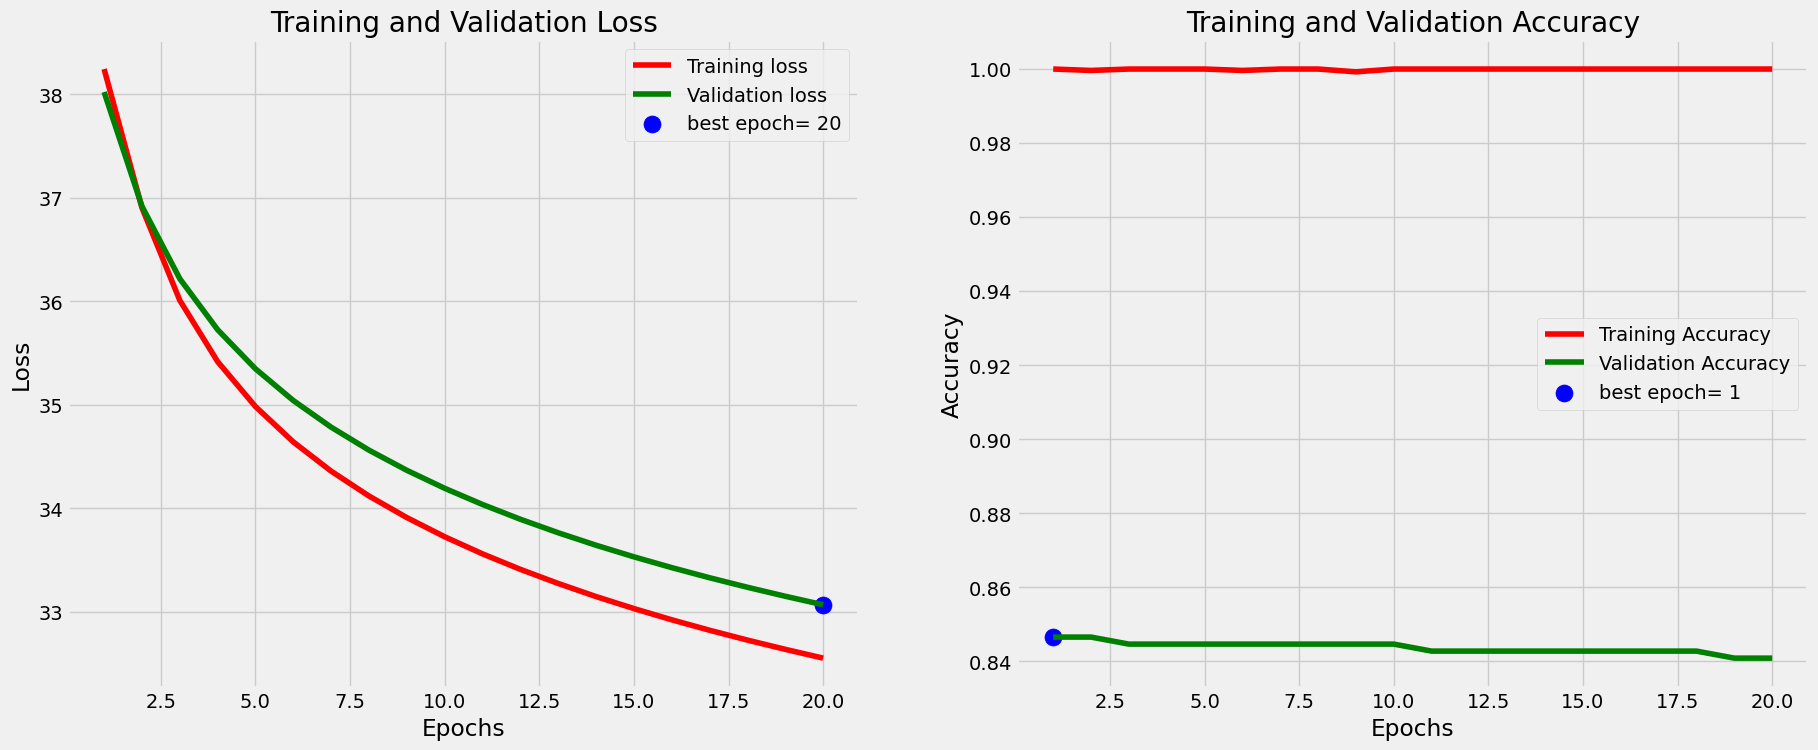

In [729]:
plot_training(history)

In [730]:
ts_length = len(y_test)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = new_model.evaluate(X_train, y_train, steps= test_steps, verbose= 1)
valid_score = new_model.evaluate(X_valid, y_valid, steps= test_steps, verbose= 1)
test_score = new_model.evaluate(X_test2,y_test2, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 0s 1ms/step - loss: 33.1484 - accuracy: 0.8561 - val_accuracy: 0.8561
Train Loss:  32.50735855102539
Train Accuracy:  1.0
--------------------
Validation Loss:  33.06737518310547
Validation Accuracy:  0.8409090638160706
--------------------
Test Loss:  33.14836883544922
Test Accuracy:  0.8560606241226196


In [1015]:
# Create a new model with a new architecture
new_model_2 = Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    keras.layers.Dense(512, kernel_regularizer= regularizers.l2(l= 0.1), activity_regularizer= regularizers.l1(0.001),
                bias_regularizer= regularizers.l1(0.001), activation='relu'),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    #keras.layers.Dropout(0.1, seed= 123),
    keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.1), activity_regularizer= regularizers.l1(0.001),
                bias_regularizer= regularizers.l1(0.001), activation='tanh'),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.01),
    keras.layers.Dropout(0.1, seed= 123),
    keras.layers.Dense(1, activation='sigmoid')
])


# Load the pre-trained weights
#new_model_2.load_weights('model_weights_86.h5')

# Load the pre-trained weights for specific layers
#new_model.load_weights('model_weights_85.h5'), by_name=True, skip_mismatch=True)

class ValAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='val_accuracy', **kwargs):
        super(ValAccuracy, self).__init__(name=name, **kwargs)
        self.accuracy = tf.keras.metrics.BinaryAccuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        self.accuracy.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.accuracy.result()

    def reset_states(self):
        self.accuracy.reset_states()

# Create an instance of the custom metric
val_accuracy = ValAccuracy()

#optimizer
from keras.optimizers import SGD
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True, decay=0.08)

# Compile the new model
new_model_2.compile(optimizer= optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',val_accuracy])

# Train the new model (optional: freeze pre-trained layers)
history=new_model_2.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_valid, y_valid))

# Evaluate the new model
accuracy = new_model_2.evaluate(X_test2, y_test2)[1]
print("Accuracy: {:.2f}".format(accuracy))

# Save the weights
if round(accuracy,2) >= 0.86:
    new_model_2.save_weights('model_weights_{}_non_transferL.h5'.format(round(accuracy,2)))

Epoch 1/20
21/21 [==============================] - 1s 19ms/step - loss: 84.8887 - accuracy: 0.6314 - val_accuracy: 0.7027 - val_loss: 82.9532 - val_val_accuracy: 0.7027
Epoch 2/20
21/21 [==============================] - 0s 12ms/step - loss: 81.7136 - accuracy: 0.7588 - val_accuracy: 0.7330 - val_loss: 80.4855 - val_val_accuracy: 0.7330
Epoch 3/20
21/21 [==============================] - 0s 12ms/step - loss: 79.6915 - accuracy: 0.7751 - val_accuracy: 0.7330 - val_loss: 78.9202 - val_val_accuracy: 0.7330
Epoch 4/20
21/21 [==============================] - 0s 12ms/step - loss: 78.3601 - accuracy: 0.7873 - val_accuracy: 0.7405 - val_loss: 77.8194 - val_val_accuracy: 0.7405
Epoch 5/20
21/21 [==============================] - 0s 12ms/step - loss: 77.3786 - accuracy: 0.7884 - val_accuracy: 0.7424 - val_loss: 76.9737 - val_val_accuracy: 0.7424
Epoch 6/20
21/21 [==============================] - 0s 12ms/step - loss: 76.6165 - accuracy: 0.7979 - val_accuracy: 0.7538 - val_loss: 76.2890 - val_v

In [995]:
new_model_2.summary()

Model: "sequential_570"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1714 (Dense)          (None, 2048)              5769216   
                                                                 
 batch_normalization_388 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_1715 (Dense)          (None, 1024)              2098176   
                                                                 
 batch_normalization_389 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dense_1716 (Dense)          (None, 256)               262400    
                                                                 
 batch_normalization_390 (Ba  (None, 256)           

In [996]:
X_train.shape, X_valid.shape, X_test2.shape

((2637, 2816), (528, 2816), (132, 2816))

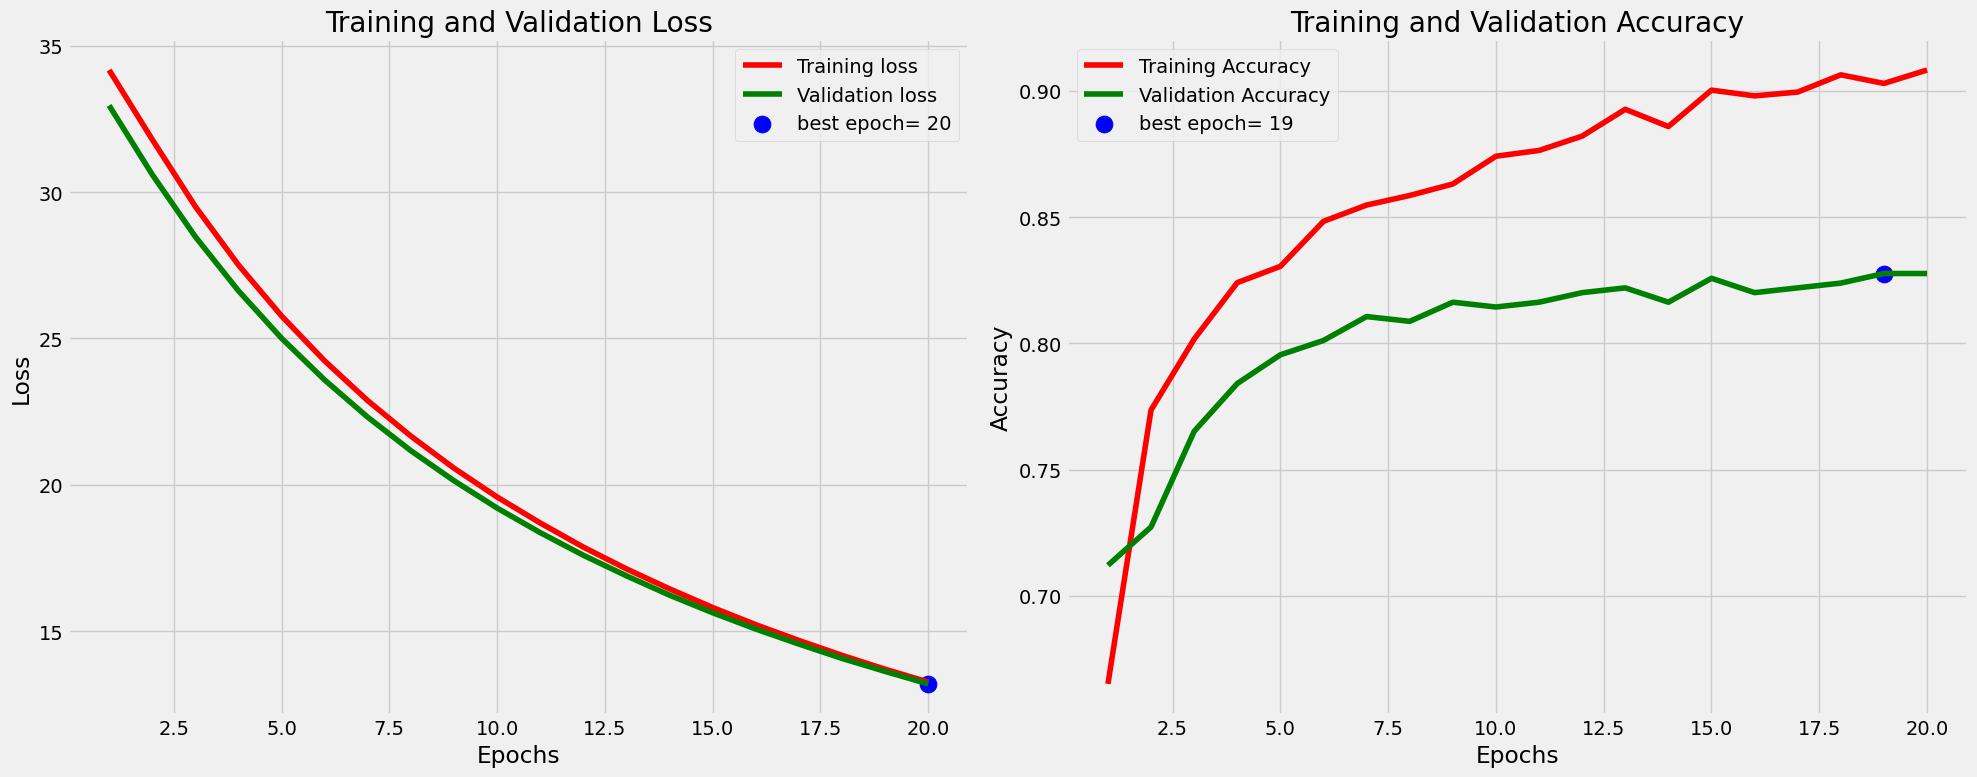

In [1010]:
plot_training(history2, 'NTL_X')

In [1009]:
ts_length = len(y_test)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = new_model_2.evaluate(X_train, y_train, steps= test_steps, verbose= 1)
valid_score = new_model_2.evaluate(X_valid, y_valid, steps= test_steps, verbose= 1)
test_score = new_model_2.evaluate(X_test2,y_test2, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 0s 3ms/step - loss: 86.2461 - accuracy: 0.8333 - val_accuracy: 0.8333
Train Loss:  86.14798736572266
Train Accuracy:  0.8797876238822937
--------------------
Validation Loss:  86.27046966552734
Validation Accuracy:  0.7878788113594055
--------------------
Test Loss:  86.2460708618164
Test Accuracy:  0.8333333134651184


In [625]:
X_valid.shape, X_test2.shape

((528, 2816), (132, 2816))

# Transformer networks using Bertmodel takes a long to finish and apparently joins an shorter accuracy!

In [921]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from transformers import TFDistilBertModel, DistilBertTokenizer
import numpy as np

# Load the pretrained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
transformer = TFDistilBertModel.from_pretrained(model_name)

# Convert numerical input data to text
X_train_text = X_train.astype(str).tolist()
X_valid_text = X_valid.astype(str).tolist()
X_test_text = X_test2.astype(str).tolist()

# Tokenize the input data
X_train_text = [str(tokens) for tokens in X_train_text]  # Convert the input data to text
input_ids_train = tokenizer(X_train_text, padding=True, truncation=True, return_tensors='tf')['input_ids']

X_valid_text = [str(tokens) for tokens in X_valid_text]  # Convert the input data to text
input_ids_valid = tokenizer(X_valid_text, padding=True, truncation=True, return_tensors='tf')['input_ids']

# Define the Transformer model
token_num = input_ids_train.shape[1]
input_layer = Input(shape=(token_num,), dtype=tf.int32)
encoder_output = transformer(input_layer).last_hidden_state[:, 0, :]
outputs = Dense(2, activation='sigmoid')(encoder_output)

modelT = tf.keras.Model(inputs=input_layer, outputs=outputs)

# Create an instance of the custom metric
class ValAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='val_accuracy', **kwargs):
        super(ValAccuracy, self).__init__(name=name, **kwargs)
        self.accuracy = tf.keras.metrics.BinaryAccuracy()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        self.accuracy.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.accuracy.result()

    def reset_states(self):
        self.accuracy.reset_states()

val_accuracy = ValAccuracy()

# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True, decay=0.004)

# Compile the model
modelT.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', val_accuracy])

# Convert the labels to categorical
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

# Train the model
historyT = modelT.fit(input_ids_train, y_train_categorical, epochs=20, batch_size=128, validation_data=(input_ids_valid, y_valid_categorical))

# Convert numerical test data to text
X_test_text = X_test2.astype(str).tolist()

# Tokenize the test data
X_test_text = [str(tokens) for tokens in X_test_text]  # Convert the test data to text
input_ids_test = tokenizer(X_test_text, padding=True, truncation=True, return_tensors='tf')['input_ids']
y_test_categorical = to_categorical(y_test)
accuracy = modelT.evaluate(input_ids_test, y_test_categorical, verbose=1)[1]
print("Accuracy: {:.2f}".format(accuracy))

# Save the weights
modelT.save_weights('modelT_weights_{}.h5'.format(round(accuracy, 2)))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/20
21/21 [==============================] - 3204s 153s/step - loss: 0.6952 - accuracy: 0.5256 - val_accuracy: 0.5455 - val_loss: 0.6861 - val_val_accuracy: 0.5644
Epoch 2/20
21/21 [==============================] - 3176s 151s/step - loss: 0.6822 - accuracy: 0.5609 - val_accuracy: 0.5833 - val_loss: 0.6785 - val_val_accuracy: 0.5928
Epoch 3/20
21/21 [==============================] - 3190s 152s/step - loss: 0.6705 - accuracy: 0.6124 - val_accuracy: 0.5795 - val_loss: 0.6692 - val_val_accuracy: 0.5862
Epoch 4/20
21/21 [==============================] - 3176s 151s/step - loss: 0.6553 - accuracy: 0.6223 - val_accuracy: 0.5909 - val_loss: 0.6709 - val_val_accuracy: 0.5909
Epoch 5/20
21/21 [==============================] - 3194s 152s/step - loss: 0.6506 - accuracy: 0.6219 - val_accuracy: 0.5966 - val_loss: 0.6730 - val_val_accuracy: 0.5947
Epoch 6/20
21/21 [==============================] - 3188s 152s/step - loss: 0.6474 - accuracy: 0.6238 - val_accuracy: 0.5928 - val_loss: 0.6704 -

KeyboardInterrupt: 